<a href="https://colab.research.google.com/github/lowkahhou/Jul19-Project-Submission-Medical-Transcription-Text-Classification-with-Glove-LSTM-BERT/blob/main/Medical_Transcription_Text_Classification_with_Glove_%2B_LSTM_%26_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Low Kah Hou

Course Period: Deep Learning Module 1 Jumpstart 4-5 July 2019

Email: lkahho2@dsta.gov.sg / lowkahhou@gmail.com

# Medical Transcription Text Classification with Glove + LSTM / BERT

**1) Objective: To classify 3 different diagnosis (i.e. Surgery, Consult - History and Phy and Radiology), out of the total 40 possible diagnosis based on Doctors' Transcription Texts**

**2) Dataset: Obtained from https://www.kaggle.com/tboyle10/medicaltranscriptions, 5000 rows of labelled text data**

**3) Challenges: Serverely imbalanced data, with classes having 6 - 100 rows of data.**

**4) Approaches:** 

         **Approach 1 (Transfer Learning Glove + LSTM):**

        i) Only consider top 3 distinct classes with resonable number of data, drop the remaining
        ii) Adjust class_weights or upsample minority classess to handle imbalanced data
        iii) Word Embedding with Pre-trained Gloved
        iv) Train & Predict with LSTM Model

         **Approach 2: (Fine Tuning BERT)**
  
        i) Only consider top 3 distinct classes with resonable number of data, drop the remaining
        ii) Train & Predict with BERT

# Approach 1: Test Classification with Glove + LSTM

In [ ]:
import numba

In [ ]:
!numba -s

System info:
--------------------------------------------------------------------------------
__Time Stamp__
2019-07-23 08:43:46.106133

__Hardware Information__
Machine                                       : x86_64
CPU Name                                      : haswell
Number of accessible CPU cores                : 2
Listed accessible CPUs cores                  : 0-1
CFS restrictions                              : None
CPU Features                                  : 
64bit aes avx avx2 bmi bmi2 cmov cx16 f16c fma fsgsbase invpcid lzcnt mmx movbe
pclmul popcnt rdrnd sahf sse sse2 sse3 sse4.1 sse4.2 ssse3 xsave xsaveopt

__OS Information__
Platform                                      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
Release                                       : 4.14.79+
System Name                                   : Linux
Version                                       : #1 SMP Wed Dec 19 21:19:13 PST 2018
OS specific info                              : Ubuntu18.04

## Import Packages

In [ ]:
!pip install -qq tf-nightly-gpu-2.0-preview
!pip install tensorflow==2.0.0b1

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant

from sklearn.metrics import classification_report

In [ ]:
print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0-beta1


## Set Parameters
**Seq Length, No. Words, Embedding Dim, Validatation_Split**

In [ ]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

##Load Pre-Trained Glove Word Embedding

In [ ]:
!wget -qq https://www.dropbox.com/s/v14xhvjmfniraf3/glove6b100dtxt.zip
# !wget -qq http://nlp.stanford.edu/data/glove.6B.zip

!unzip glove6b100dtxt.zip

Archive:  glove6b100dtxt.zip
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!ls

BertModel.h5	    glove6b100dtxt.zip.1  mtsamples.csv.2
glove.6B.100d.txt   mtsamples.csv	  OUTPUT_DIR_NAME
glove6b100dtxt.zip  mtsamples.csv.1	  sample_data


In [ ]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open('./glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


## Glove Embedding Example 

In [ ]:
embeddings_index['cardiovascular']

array([-0.063927 , -0.24056  , -0.4748   ,  0.26566  , -0.58629  ,
       -0.34764  ,  0.19974  , -0.21486  , -0.95679  ,  0.11892  ,
       -0.064613 ,  0.029716 ,  0.12213  , -0.42699  ,  0.53195  ,
        0.33944  , -0.50342  , -0.15205  , -0.010427 , -0.63419  ,
       -0.42881  , -0.88133  , -0.17609  ,  0.3787   , -0.57562  ,
        1.1164   ,  0.27586  , -0.89914  , -0.38188  , -0.082689 ,
        0.22638  , -0.11732  , -0.63669  ,  0.1358   , -0.11595  ,
        0.11031  , -0.15326  ,  1.2685   , -0.50569  ,  0.50787  ,
        0.046222 ,  0.44515  , -0.18485  , -1.5424   ,  0.18502  ,
        0.89334  ,  0.36487  , -0.28431  , -1.1815   , -0.48648  ,
        0.69814  , -0.37454  , -0.5543   , -0.3999   ,  0.90543  ,
       -0.58994  ,  0.85362  , -0.25272  , -0.0046577,  0.43691  ,
        0.08117  ,  0.63046  ,  0.76397  ,  0.086914 , -0.44626  ,
        0.43249  , -0.45881  , -0.43386  ,  1.1766   ,  0.17748  ,
       -0.20207  , -0.27667  ,  0.28324  ,  1.1139   , -0.0476

In [ ]:
embeddings_index['gastric']

array([-0.2825   , -0.89428  , -0.56487  , -0.38483  ,  0.12684  ,
        0.3344   ,  0.17071  ,  0.051757 ,  0.82585  ,  0.56991  ,
        0.026795 ,  0.53249  , -0.46824  , -0.54844  ,  0.68028  ,
       -0.51401  , -1.1778   , -0.60751  ,  1.7644   , -0.77113  ,
        0.028847 , -0.60926  , -0.465    ,  0.49462  , -0.3023   ,
        0.85926  ,  0.61845  , -1.0996   ,  1.0218   , -0.020832 ,
       -0.32259  ,  0.19452  , -0.2763   , -0.11358  ,  0.54191  ,
        0.033256 , -0.10632  ,  0.66825  ,  0.26577  , -0.39179  ,
        0.45718  ,  0.037472 , -0.063422 , -1.3421   ,  0.12779  ,
        1.3521   , -0.35607  , -0.6323   , -0.36377  ,  0.7356   ,
       -0.065951 , -0.0058264, -0.0028454, -0.53912  , -0.70949  ,
       -0.08351  ,  0.51416  , -1.2381   , -0.57439  ,  0.70608  ,
        0.32264  ,  0.72549  ,  0.94441  , -0.1301   ,  0.32396  ,
        0.39454  , -0.304    , -1.2304   ,  0.12846  , -0.88076  ,
       -0.39799  ,  0.74002  ,  0.24833  ,  0.33528  , -0.4306

In [ ]:
embeddings_index['vasectomy']

array([ 1.2123   ,  0.19251  , -0.50487  ,  0.3131   , -0.77586  ,
        0.1057   ,  0.59309  ,  0.58455  , -0.2151   ,  0.11593  ,
       -0.26653  ,  0.54038  ,  0.17297  ,  0.32213  ,  0.11309  ,
        0.42065  , -0.50265  , -0.28663  ,  0.19888  ,  0.015675 ,
        0.068743 , -0.15986  , -0.623    ,  0.15374  , -0.29185  ,
        0.47288  , -0.23803  ,  0.028133 , -0.11611  , -0.72674  ,
        0.61179  ,  0.14748  , -0.27585  ,  0.063164 ,  0.43582  ,
       -0.12671  , -0.31046  , -0.091105 , -0.20647  , -0.22795  ,
        0.26988  ,  0.32923  ,  0.2268   , -0.029177 , -0.87744  ,
       -0.096877 ,  0.42638  , -0.012426 ,  0.019951 , -0.21522  ,
       -0.32499  , -0.090643 ,  0.18164  ,  0.055042 ,  0.016539 ,
        0.36179  ,  0.099829 , -0.016484 , -0.59487  , -0.13349  ,
       -0.49693  , -0.23601  ,  1.0018   , -0.026892 ,  0.046848 ,
        0.38903  ,  0.056592 , -0.39049  ,  0.092257 , -0.01742  ,
       -0.83432  ,  0.45548  , -0.0095826,  0.84399  , -0.0679

## Load and Clean dataset

1) Drop irrelavent columns

2) Drop NA

3) Filter top 3 distinct classes

In [ ]:
!wget -qq https://www.dropbox.com/s/pcnw03zeq96er2b/mtsamples.csv

N


In [ ]:
# # Run this cell to mount your Google Drive.
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('./mtsamples.csv')
df.drop(columns= ['Unnamed: 0', 'description', 'sample_name', 'keywords'], inplace = True)
df.columns = ['Labels', 'Transcriptions']
df.head()

,Labels,Transcriptions
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


In [ ]:
df.isna().sum()

Labels             0
Transcriptions    33
dtype: int64

In [ ]:
df.dropna(inplace = True)

In [ ]:
df['Labels'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

In [ ]:
labels_filtered = [' Surgery', ' Consult - History and Phy.', ' Radiology']
labels_filtered

[' Surgery', ' Consult - History and Phy.', ' Radiology']

In [ ]:
df = df[df['Labels'].isin(labels_filtered)]

In [ ]:
texts = df['Transcriptions']

In [ ]:
labels_index = {}  # dictionary mapping label name to numeric id

for index, label in enumerate(list(pd.Series(df['Labels']).unique())):
  labels_index[label] = index
  
labels_index

{' Consult - History and Phy.': 2, ' Radiology': 1, ' Surgery': 0}

In [ ]:
df['labels_index'] = [labels_index[label] for label in df['Labels']]
labels = df['labels_index']

df.head()

,Labels,Transcriptions,labels_index
174,Surgery,"PREOPERATIVE DIAGNOSES:,1. Hallux rigidus, le...",0
177,Surgery,"PREOPERATIVE DIAGNOSIS: , Secondary capsular m...",0
179,Surgery,"TITLE OF OPERATION: , Youngswick osteotomy wit...",0
181,Surgery,"PREOPERATIVE DIAGNOSES,1. Open wound from rig...",0
182,Surgery,"PREOPERATIVE DIAGNOSIS:, Visually significant...",0


## Tokenize the words 

In [ ]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(lower= True, num_words= MAX_NUM_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 20560 unique tokens.


## Pad the sequences so that they are all the same

In [ ]:
data = pad_sequences(sequences, maxlen= MAX_SEQUENCE_LENGTH)

## Upsampling with SMOTE (Attempted but drop this approach due to bad accuracy) 
**Instead will adjust class weights to handle imbalanced class**

In [ ]:
# pd.Series(labels).value_counts()

In [ ]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)

# data, labels = sm.fit_resample(data, labels)

In [ ]:
# pd.Series(labels).value_counts()

## OHE labels

In [ ]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (1877, 1000)
Shape of label tensor: (1877, 3)


## Make a train test split

In [ ]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [ ]:
x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [ ]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)

x_train shape: (1502, 1000)
y_train shape: (1502, 3)
x_val shape: (375, 1000)
y_val shape: (375, 3)


## Matrix for embedding

In [ ]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Preparing embedding matrix.


## Compile Model and Run

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(32, dropout= 0.4)(embedded_sequences)
preds = Dense(len(labels_index), activation='softmax')(x)

In [ ]:
model = Model(sequence_input, preds)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         2000100   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 2,017,223
Trainable params: 17,123
Non-trainable params: 2,000,100
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.0015)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [ ]:
history = model.fit(x_train, y_train,
          batch_size= 288,
          epochs= 50,
          validation_data=(x_val, y_val),
          class_weight = True)

W0707 13:44:00.679773 140435022550912 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1502 samples, validate on 375 samples
Epoch 1/50
1502/1502 [==============================] - 16s 11ms/sample - loss: 1.1298 - acc: 0.3402 - val_loss: 0.9360 - val_acc: 0.5973
Epoch 2/50
1502/1502 [==============================] - 13s 9ms/sample - loss: 0.9168 - acc: 0.5945 - val_loss: 0.8606 - val_acc: 0.6027
Epoch 3/50
1502/1502 [==============================] - 14s 9ms/sample - loss: 0.8618 - acc: 0.5839 - val_loss: 0.8338 - val_acc: 0.6027
Epoch 4/50
1502/1502 [==============================] - 13s 8ms/sample - loss: 0.8378 - acc: 0.6085 - val_loss: 0.8055 - val_acc: 0.6347
Epoch 5/50
1502/1502 [==============================] - 13s 9ms/sample - loss: 0.8021 - acc: 0.6132 - val_loss: 0.7601 - val_acc: 0.6427
Epoch 6/50
1502/1502 [==============================] - 13s 9ms/sample - loss: 0.7443 - acc: 0.6525 - val_loss: 0.6835 - val_acc: 0.7120
Epoch 7/50
1502/1502 [==============================] - 13s 9ms/sample - loss: 0.6655 - acc: 0.7204 - val_loss: 0.6285 - val_acc: 

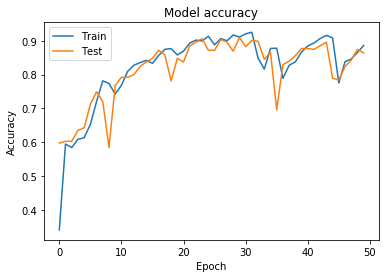

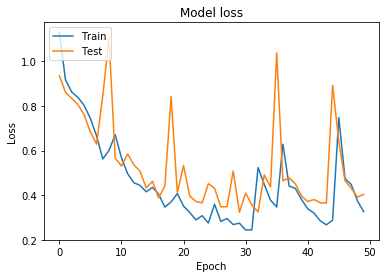

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
y_predict = model.predict(x_val)
print(classification_report(y_val.argmax(axis=1), y_predict.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       225
           1       0.82      0.44      0.57        52
           2       0.86      0.85      0.86        98

    accuracy                           0.86       375
   macro avg       0.85      0.75      0.78       375
weighted avg       0.86      0.86      0.85       375



# Conclusion for Approach 1

Model performed fairly well for Class 0: Surgery and Class 2: Consult - History and Phy. with recall score >= 0.85

However, model is not particularly good at identifying Class 1: Radiology. Suspect it could be due to insufficient distinct features for this class. 

# Approach 2: Multi-Label Classification with BERT

Most of the codes below are extracted online

# Import Packages

Require to downgrade tensorflow version to 1.13.1. 

Comment: Would like to find compatible codes for tensorflow 2.0 



In [ ]:
!pip install bert-tensorflow
!pip install tensorflow==1.12.3 # Codes below require 1.13.1

     |████████████████████████████████| 83.1MB 1.6MB/s 
     |████████████████████████████████| 3.1MB 27.8MB/s 
  Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Found existing installation: tensorflow 2.0.0b1
    Uninstalling tensorflow-2.0.0b1:
      Successfully uninstalled tensorflow-2.0.0b1


In [ ]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
import numpy as np
from bert.tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

# Initialize session
sess = tf.Session()

# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length = 256

W0707 14:05:37.292586 139787065431936 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [ ]:
print(tf.keras.__version__)
print(tf.__version__)

2.1.6-tf
1.12.3


## Load and Clean dataset

In [ ]:
!wget -qq https://www.dropbox.com/s/pcnw03zeq96er2b/mtsamples.csv

In [ ]:
df = pd.read_csv('./mtsamples.csv')
df.drop(columns= ['Unnamed: 0', 'description', 'sample_name', 'keywords'], inplace = True)
df.columns = ['Labels', 'Transcriptions']
df.head()

,Labels,Transcriptions
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


In [ ]:
df.isna().sum()

Labels             0
Transcriptions    33
dtype: int64

In [ ]:
df.dropna(inplace = True)

In [ ]:
df['Labels'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Dentistry                          27
 Cosmetic / Plastic Surge

In [ ]:
labels_filtered = [' Surgery', ' Consult - History and Phy.', ' Radiology']
labels_filtered

[' Surgery', ' Consult - History and Phy.', ' Radiology']

In [ ]:
df = df[df['Labels'].isin(labels_filtered)]

In [ ]:
texts = df['Transcriptions']

In [ ]:
labels_index = {}  # dictionary mapping label name to numeric id

for index, label in enumerate(list(pd.Series(df['Labels']).unique())):
  labels_index[label] = index
  
labels_index

{' Consult - History and Phy.': 2, ' Radiology': 1, ' Surgery': 0}

In [ ]:
df['labels_index'] = [labels_index[label] for label in df['Labels']]
labels = df['labels_index']

df.head()

,Labels,Transcriptions,labels_index
174,Surgery,"PREOPERATIVE DIAGNOSES:,1. Hallux rigidus, le...",0
177,Surgery,"PREOPERATIVE DIAGNOSIS: , Secondary capsular m...",0
179,Surgery,"TITLE OF OPERATION: , Youngswick osteotomy wit...",0
181,Surgery,"PREOPERATIVE DIAGNOSES,1. Open wound from rig...",0
182,Surgery,"PREOPERATIVE DIAGNOSIS:, Visually significant...",0


In [ ]:
x = df['Transcriptions']
y = df['labels_index']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify = y)

train_df = pd.DataFrame(x_train)
train_df['labels_index'] = y_train

test_df = pd.DataFrame(x_test)
test_df['labels_index'] = y_test

In [ ]:
# Create datasets (Only take up to max_seq_length words for memory)
train_text = train_df['Transcriptions'].tolist()
train_text = [' '.join(t.split()[0:max_seq_length]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_df['labels_index'].tolist()

test_text = test_df['Transcriptions'].tolist()
test_text = [' '.join(t.split()[0:max_seq_length]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = test_df['labels_index'].tolist()

# Tokenize

Next, tokenize our text to create `input_ids`, `input_masks`, and `segment_ids`

In [ ]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_label)
test_examples = convert_text_to_examples(test_text, test_label)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0707 14:05:59.475172 139787065431936 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


## Build Model and Run

In [ ]:
class BertLayer(tf.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="first",
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [ ]:
# Build model
def build_model(max_seq_length): 
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=3, pooling="first")(bert_inputs)
    dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)


In [ ]:
model = build_model(max_seq_length)

# Instantiate variables
initialize_vars(sess)

histroy = model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=5,
    batch_size=32
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0707 14:06:14.254176 139787065431936 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0707 14:06:16.590291 139787065431936 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 256)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 256)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 256)          0                                            
__________________________________________________________________________________________________
bert_layer_1 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]                
          

In [ ]:
model.save('BertModel.h5')
pre_save_preds = model.predict([test_input_ids[0:100], 
                                test_input_masks[0:100], 
                                test_segment_ids[0:100]]
                              ) # predictions before we clear and reload model

# Clear and load model
model = None
model = build_model(max_seq_length)
initialize_vars(sess)
model.load_weights('BertModel.h5')

post_save_preds = model.predict([test_input_ids[0:100], 
                                test_input_masks[0:100], 
                                test_segment_ids[0:100]]
                              ) # predictions after we clear and reload model
all(pre_save_preds == post_save_preds) # Are they the same?

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0707 21:01:13.950089 139787065431936 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0707 21:01:16.439804 139787065431936 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 256)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 256)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 256)          0                                            
__________________________________________________________________________________________________
bert_layer_2 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]                
          

True

# Conclusion/ Areas for Improvement for Approach 2

Accuracy is very low.

Also insufficient knowledge about the BERT model and codes to be able to tweat to my context.

Training for each epoch is long, about 4900 secs, may be because i am using Tensorflow version 1.12.3 which is not optimised for language model training.